In this jupyter notebook I import a dataset containing crime-related information in Baton Rouge from the past 10 years and use it to build a decision tree in order to predict what type of crime is committed depending on various factors including whether the crime is 'succesfully' committed vs attempted, the time of day, the season, the area of the city, etc. The goal is to help law enforcement identify when and in which areas of Baton Rouge to use more resources and/or the correct type of crime prevention resources in that area (i.e assign more DEA staff to a district that tends to have more drug-related crimes that actually happen as opposed to just being attempted and at the appropriate time, assign more experienced policemen in areas with more violent crime at specific times of the day when the violence is the heaviest, etc.)

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

crime_data = pd.read_csv('Legacy_Baton_Rouge_Crime_Incidents.csv', sep=",", header=0, low_memory=False)
print(crime_data.head())

   FILE NUMBER OFFENSE DATE OFFENSE TIME           CRIME  COMMITTED  \
0          NaN      11/1/19         1844        JUVENILE  COMMITTED   
1          NaN       1/1/13            0  SEXUAL ASSAULT  COMMITTED   
2          NaN       4/2/20         1100        JUVENILE  COMMITTED   
3          NaN      2/13/14         1015  SEXUAL ASSAULT  COMMITTED   
4          NaN      3/24/19          100  SEXUAL ASSAULT  COMMITTED   

     OFFENSE           OFFENSE DESCRIPTION FULL ADDRESS  ADDRESS NUMBER  \
0  14:93.2.1               CHILD DESERTION          NaN             NaN   
1    14:42/O               RAPE/AGG (ORAL)          NaN             NaN   
2    15:33.4  EXPLOITATION OF THE INFIRMED          NaN             NaN   
3  14:42.1/V       RAPE/FORCIBLE (VAGINAL)          NaN             NaN   
4    14:43.1                   BATT/SEXUAL          NaN             NaN   

  STREET DIRECTION  ... CITY STATE ZIP CODE DISTRICT  ZONE SUBZONE  \
0              NaN  ...  NaN   NaN  70808.0        2

In [52]:
#extract month from date column and create the 'season' column based on which month it is
season = []
for index, row in crime_data.iterrows():
    
    if row['OFFENSE DATE'][1] == '/':
        if row['OFFENSE DATE'][0].isdigit():
            if int(row['OFFENSE DATE'][0]) < 3:
                newSeason = 'Winter'
            elif int(row['OFFENSE DATE'][0]) > 2 and int(row['OFFENSE DATE'][0]) < 6:
                newSeason = 'Spring'
            elif int(row['OFFENSE DATE'][0]) > 5 and int(row['OFFENSE DATE'][0]) < 9:
                newSeason = 'Summer'
            else:
                newSeason = 'Fall'
        else:
            newSeason = None
    else:
        if row['OFFENSE DATE'][0].isdigit() and row['OFFENSE DATE'][1].isdigit():
            if int(row['OFFENSE DATE'][:2]) < 3 or int(row['OFFENSE DATE'][:2]) == 12:
                    newSeason = 'Winter'
            elif int(row['OFFENSE DATE'][:2]) > 2 and int(row['OFFENSE DATE'][:2]) < 6:
                newSeason = 'Spring'
            elif int(row['OFFENSE DATE'][:2]) > 5 and int(row['OFFENSE DATE'][:2]) < 9:
                newSeason = 'Summer'
            else:
                newSeason = 'Fall'
        else:
            newSeason = None
    
    season.append(newSeason)
    
#add season column to data
df = pd.DataFrame(season, columns=['SEASON'])
crime_data = pd.concat([crime_data, df], axis=1)

#create the 'Time of Day' column based on the 'Offense Time' column in the data
timeOfDay = []
for index, row in crime_data.iterrows():
    if len(row['OFFENSE TIME']) == 1:
        if row['OFFENSE TIME'][0].isdigit(): 
            if int(row['OFFENSE TIME'][0]) < 6:
                newTimeOfDay = 'Late Night'
            else:
                newTimeOfDay = 'Morning'
        else:
            newTimeOfDay = None
    else:
        if row['OFFENSE TIME'][0].isdigit() and row['OFFENSE TIME'][1].isdigit():
            if int(row['OFFENSE TIME'][:2]) < 6:
                    newTimeOfDay = 'Late Night'
            elif int(row['OFFENSE TIME'][:2]) > 5 and int(row['OFFENSE TIME'][:2]) < 12:
                newTimeOfDay = 'Morning'
            elif int(row['OFFENSE TIME'][:2]) > 11 and int(row['OFFENSE TIME'][:2]) < 17:
                newTimeOfDay = 'Afternoon'
            elif int(row['OFFENSE TIME'][:2]) > 16 and int(row['OFFENSE TIME'][:2]) < 21:
                newTimeOfDay = 'Evening'
            else:
                newtimeOfDay = 'Early Night'    
        else:
            newTimeOfDay = None
        
    timeOfDay.append(newTimeOfDay)
        

#add timeOfDay column to data
df = pd.DataFrame(timeOfDay, columns=['TIME OF DAY'])
crime_data = pd.concat([crime_data, df], axis=1)

#Create area column to show which area of Baton Rouge the crime occurred in based on the zip code
area = []
for index, row in crime_data.iterrows():
    if row['ZIP CODE'] == 70803 or row['ZIP CODE'] == 70808 or row['ZIP CODE'] == 70810 or row['ZIP CODE'] == 70836 or row['ZIP CODE'] == 70820:
        newArea = 'Southwest'
    elif row['ZIP CODE'] == 70809 or row['ZIP CODE'] == 70817 or row['ZIP CODE'] == 70816:
        newArea = 'Southeast'
    elif row['ZIP CODE'] == 70801 or row['ZIP CODE'] == 70802 or row['ZIP CODE'] == 70806 or row['ZIP CODE'] == 70819 or row['ZIP CODE'] == 70815:
        newArea = 'Central'
    elif row['ZIP CODE'] == 70805 or row['ZIP CODE'] == 70813 or row['ZIP CODE'] == 70807:
        newArea = 'Northwest'
    elif row['ZIP CODE'] == 70811 or row['ZIP CODE'] == 70818 or row['ZIP CODE'] == 70812 or row['ZIP CODE'] == 70814:
        newArea = 'Northeast'
    else:
        newArea = None
    
    area.append(newArea)

#add area column to data
df = pd.DataFrame(area, columns=['AREA'])
crime_data = pd.concat([crime_data, df], axis=1)

#drop not needed features
crime_data = crime_data.drop(columns=['FILE NUMBER', 'OFFENSE DATE', 'OFFENSE', 'OFFENSE TIME', 'OFFENSE DESCRIPTION', 'FULL ADDRESS',
                        'ADDRESS NUMBER', 'STREET DIRECTION', 'DISTRICT', 'ZONE', 'SUBZONE', 'COMPLETE DISTRICT',
                        'COUNCIL DISTRICT', 'GEOLOCATION', 'STREET NAME', 'STREET TYPE', 'CITY', 'STATE', 'ZIP CODE'])

#drop rows with N/A's or missing values
crime_data = crime_data.dropna()
crime_data = crime_data.reset_index(drop=True)

#make crime prevention district and committed columns binary indicattors (0 or 1)
for index, row in crime_data.iterrows():
    if row['CRIME PREVENTION DISTRICT'] == 'NONE':
        crime_data.at[index,'CRIME PREVENTION DISTRICT'] = 0    
    else:
        crime_data.at[index,'CRIME PREVENTION DISTRICT'] = 1    
        
    if row['COMMITTED'] == 'COMMITTED':
        crime_data.at[index,'COMMITTED'] = 1    
    else: 
        crime_data.at[index,'COMMITTED'] = 0    

        
        
#make categorical variables binary indicators
categorical = pd.get_dummies(crime_data[['SEASON','TIME OF DAY', 'AREA']])
crime_data = pd.concat([crime_data, categorical], axis=1)

crime_data = crime_data.drop(columns=['SEASON', 'TIME OF DAY', 'AREA'])


print(crime_data.head())

            CRIME COMMITTED CRIME PREVENTION DISTRICT  SEASON_Fall  \
0        JUVENILE         1                         0            1   
1        JUVENILE         1                         0            0   
2  SEXUAL ASSAULT         1                         0            0   
3  SEXUAL ASSAULT         1                         0            0   
4  SEXUAL ASSAULT         1                         0            0   

   SEASON_Spring  SEASON_Summer  SEASON_Winter  TIME OF DAY_Afternoon  \
0              0              0              0                      0   
1              1              0              0                      0   
2              0              0              1                      0   
3              1              0              0                      0   
4              1              0              0                      0   

   TIME OF DAY_Evening  TIME OF DAY_Late Night  TIME OF DAY_Morning  \
0                    1                       0                    0  

[Text(0.5, 0.875, 'AREA_Southwest <= 0.5\ngini = 0.852\nsamples = 388739\nvalue = [16366, 34291, 778, 29842, 13212, 3219, 5786, 4042\n34258, 12864, 9480, 104314, 12836, 1751, 83082, 21086\n1532]\nclass = ASSAULT'),
 Text(0.25, 0.625, 'COMMITTED <= 0.5\ngini = 0.859\nsamples = 331797\nvalue = [15013, 31141, 658, 26454, 12179, 3022, 5147, 3621\n30910, 11349, 8482, 81870, 11037, 1517, 71769, 16225\n1403]\nclass = ASSAULT'),
 Text(0.125, 0.375, 'AREA_Northwest <= 0.5\ngini = 0.857\nsamples = 7303\nvalue = [87, 114, 60, 90, 116, 1762, 439, 21, 78, 760, 13\n1088, 844, 78, 1237, 514, 2]\nclass = NARCOTICS'),
 Text(0.0625, 0.125, 'gini = 0.862\nsamples = 4727\nvalue = [50, 72, 36, 58, 80, 943, 285, 13, 54, 523, 10\n650, 544, 51, 975, 381, 2]\nclass = VICE'),
 Text(0.1875, 0.125, 'gini = 0.83\nsamples = 2576\nvalue = [37, 42, 24, 32, 36, 819, 154, 8, 24, 237, 3, 438\n300, 27, 262, 133, 0]\nclass = NARCOTICS'),
 Text(0.375, 0.375, 'AREA_Northwest <= 0.5\ngini = 0.857\nsamples = 324494\nvalue = [

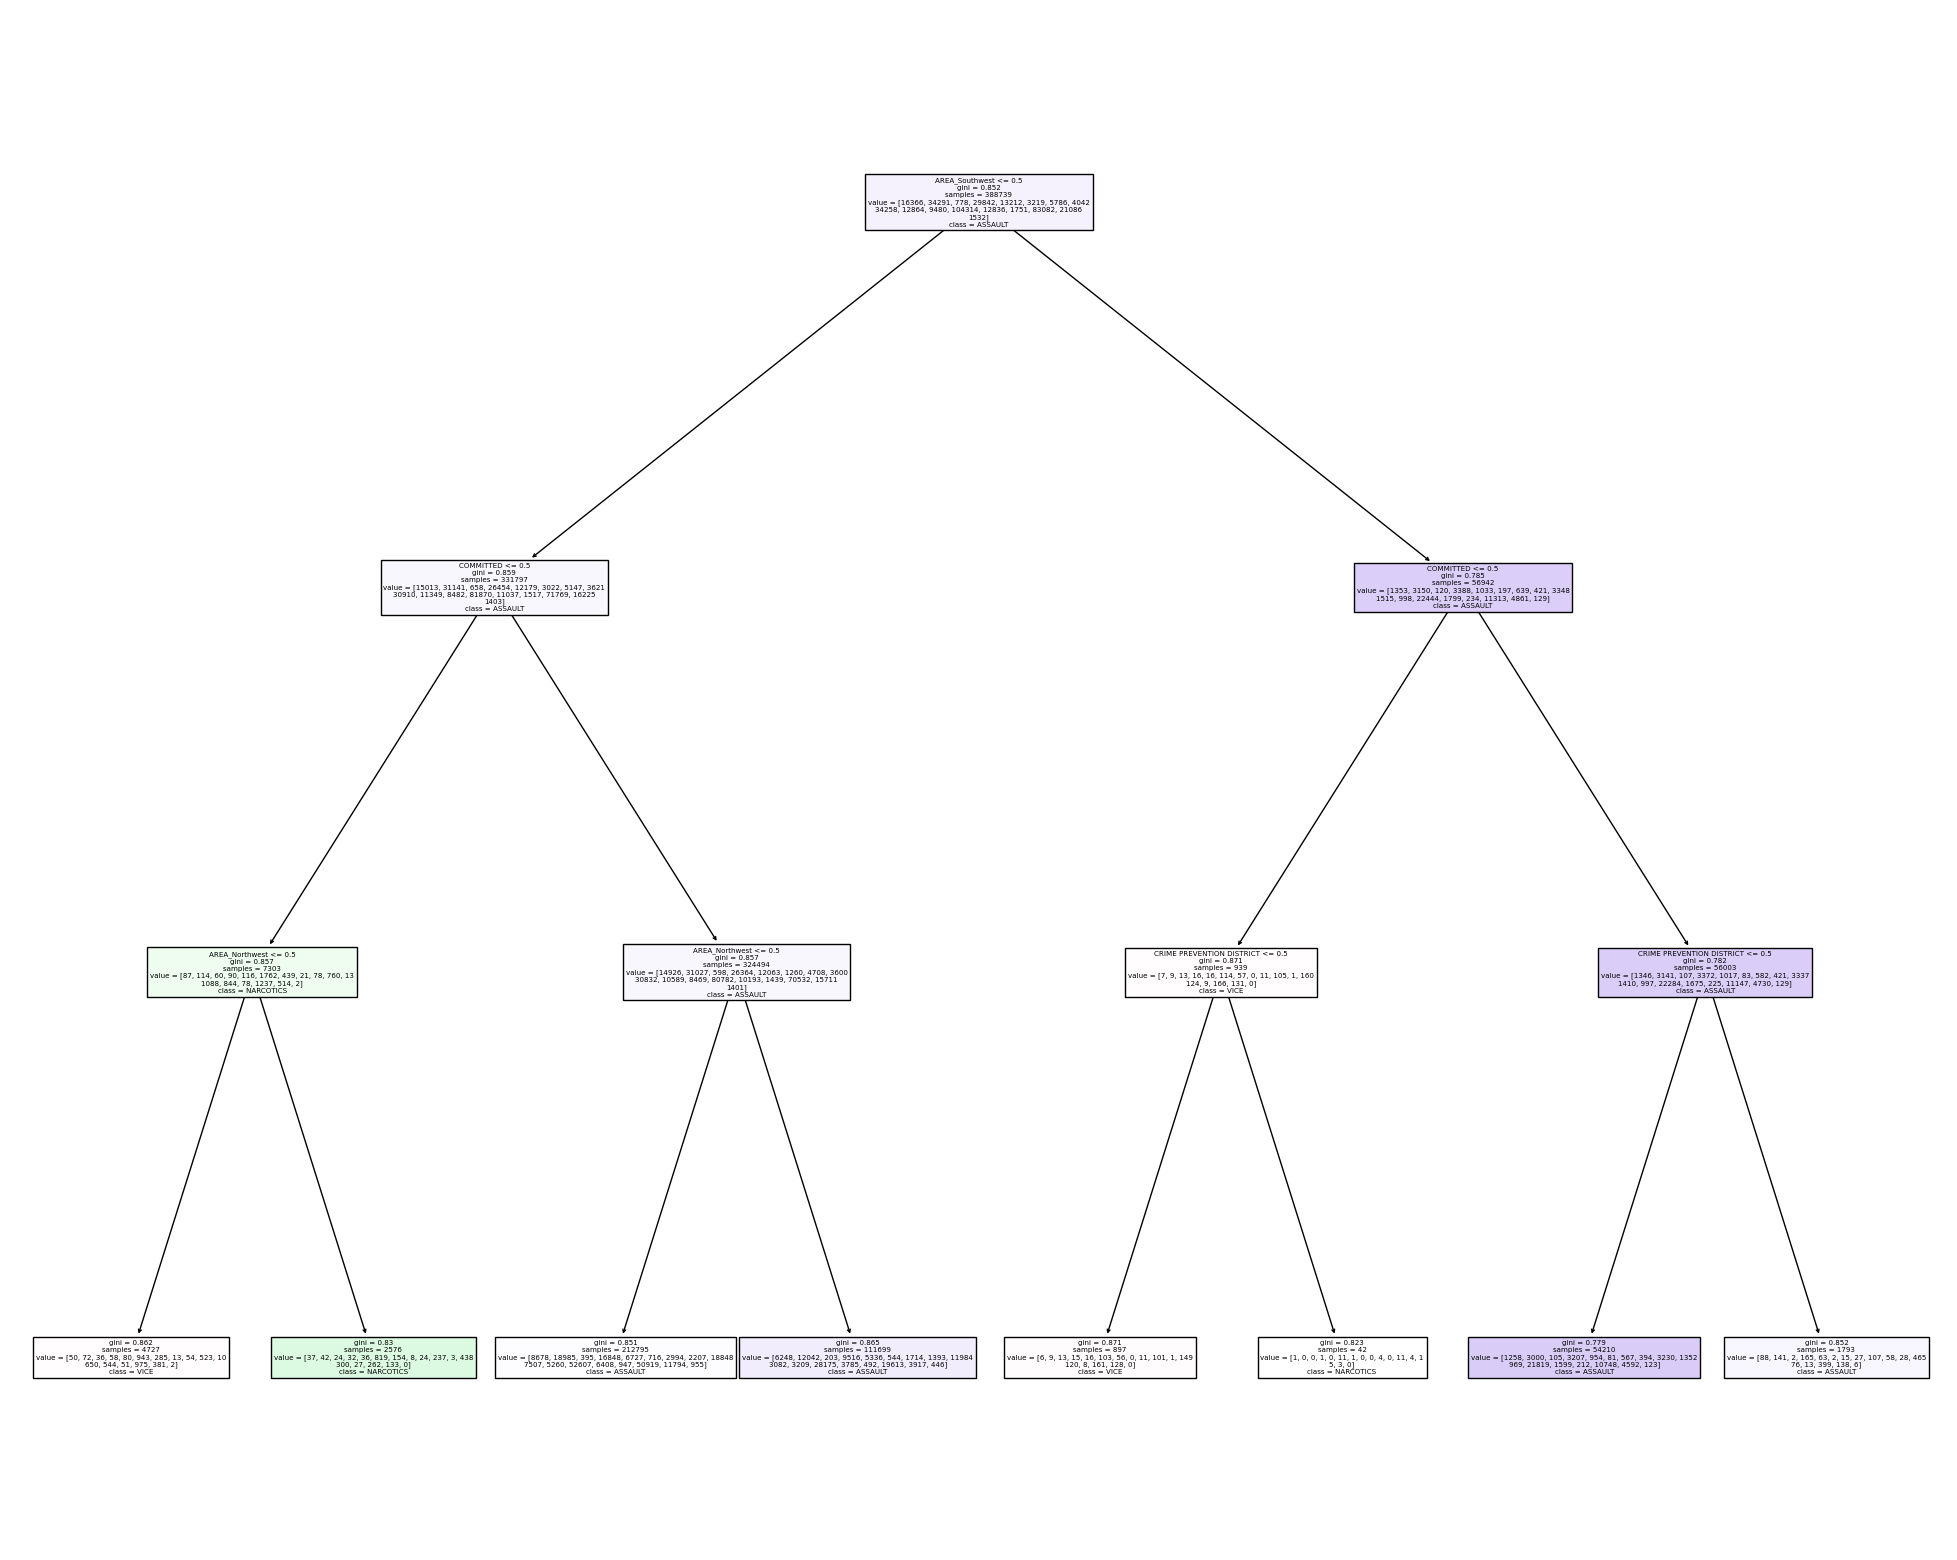

In [53]:
#split data and implement decision tree algorithm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


x_data = crime_data[['COMMITTED','CRIME PREVENTION DISTRICT', 'SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer',
                    'SEASON_Winter', 'TIME OF DAY_Afternoon', 'TIME OF DAY_Evening', 'TIME OF DAY_Late Night', 
                    'TIME OF DAY_Morning', 'AREA_Central', 'AREA_Northeast', 'AREA_Northwest', 'AREA_Southeast',
                     'AREA_Southwest']]
y_data = crime_data[['CRIME']]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(x_train, y_train)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_clf, 
                    feature_names=x_data.columns,  
                    class_names=y_data.astype(str).CRIME.unique(),
                    filled=True)

In [29]:
tree_clf.score(x_test, y_test)

0.2697124041775994

0.28050625096465504

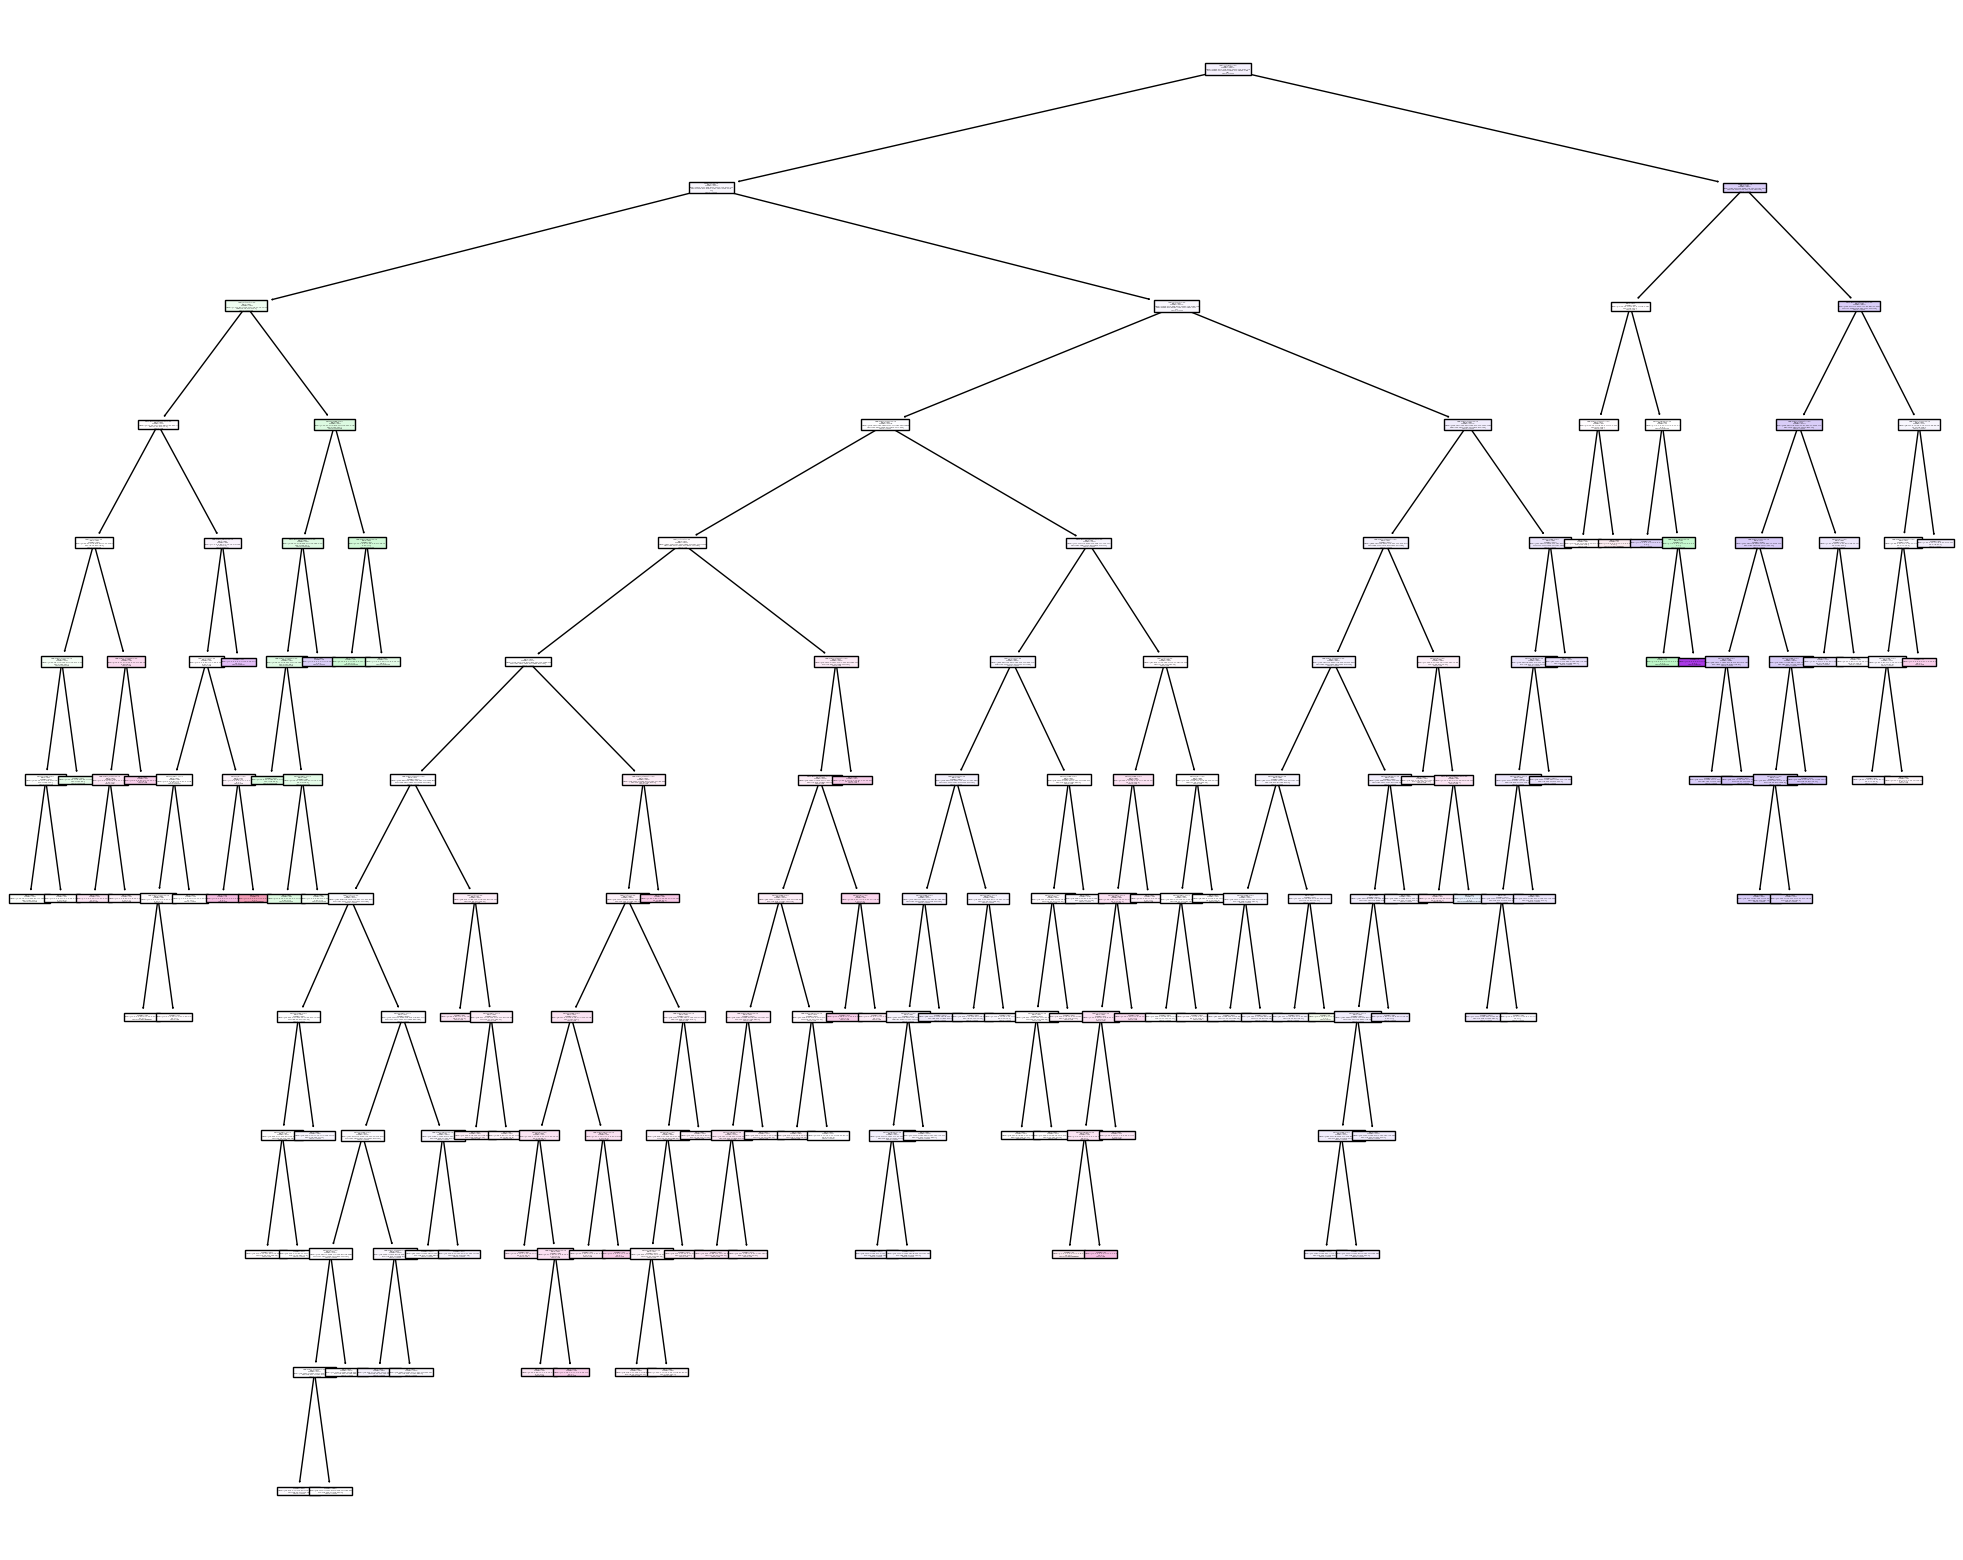

In [48]:
#build new tree with higher max_depth and max_leaf_nodes features to make algorithm more complex and diverse in its classifications
tree_clf_2 = DecisionTreeClassifier(max_depth=30, random_state=42, max_leaf_nodes=100)
tree_clf_2.fit(x_train, y_train)
tree_clf_2.score(x_test, y_test)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_clf_2, 
                    feature_names=x_data.columns,  
                    class_names=y_data.astype(str).CRIME.unique(),
                    filled=True)

tree_clf_2.score(x_test, y_test)

In [30]:
#attempting to help the accuracy of the algorithm by reducing the number of potential classifications
newClasses = []
for index, row in crime_data.iterrows():
    if row['CRIME'] == 'JUVENILE' or row['CRIME'] == 'OTHER' or row['CRIME'] == 'CRIMINAL DAMAGE TO PROPERTY' or row['CRIME'] =='NUISANCE':
        newClass = 'Minor'
    elif row['CRIME'] == 'SEXUAL ASSAULT' or row['CRIME'] == 'BATTERY' or row['CRIME'] == 'ASSAULT' or row['CRIME'] == 'HOMICIDE' or row['CRIME'] == 'FIREARM':
        newClass = 'Violent'
    elif row['CRIME'] == 'THEFT' or row['CRIME'] == 'RESIDENTIAL BURGLARY' or row['CRIME'] == 'NON-RESIDENTIAL BURGLARY' or row['CRIME'] == 'INDIVIDUAL ROBBERY' or row['CRIME'] == 'BUSINESS ROBBERY' or row['CRIME'] == 'VEHICLE BURGLARY':
        newClass = 'Theft'
    elif row['CRIME'] == 'NARCOTICS' or row['CRIME'] == 'VICE':
        newClass = 'Drugs'
    else:
        newClass = None
    
    newClasses.append(newClass)

#add area column to data
df = pd.DataFrame(newClasses, columns=['CRIME_NEW'])
crime_data = pd.concat([crime_data, df], axis=1)

[Text(0.5, 0.875, 'AREA_Southwest <= 0.5\ngini = 0.693\nsamples = 388739\nvalue = [35790, 147678, 136432, 68839]\nclass = Violent'),
 Text(0.25, 0.625, 'AREA_Northwest <= 0.5\ngini = 0.7\nsamples = 331797\nvalue = [32313, 120427, 116185, 62872]\nclass = Violent'),
 Text(0.125, 0.375, 'COMMITTED <= 0.5\ngini = 0.69\nsamples = 217522\nvalue = [19859, 77653, 82761, 37249]\nclass = Theft'),
 Text(0.0625, 0.125, 'gini = 0.575\nsamples = 4727\nvalue = [56, 731, 2744, 1196]\nclass = Theft'),
 Text(0.1875, 0.125, 'gini = 0.691\nsamples = 212795\nvalue = [19803, 76922, 80017, 36053]\nclass = Theft'),
 Text(0.375, 0.375, 'COMMITTED <= 0.5\ngini = 0.712\nsamples = 114275\nvalue = [12454, 42774, 33424, 25623]\nclass = Violent'),
 Text(0.3125, 0.125, 'gini = 0.64\nsamples = 2576\nvalue = [24, 481, 1110, 961]\nclass = Theft'),
 Text(0.4375, 0.125, 'gini = 0.712\nsamples = 111699\nvalue = [12430, 42293, 32314, 24662]\nclass = Violent'),
 Text(0.75, 0.625, 'COMMITTED <= 0.5\ngini = 0.63\nsamples = 569

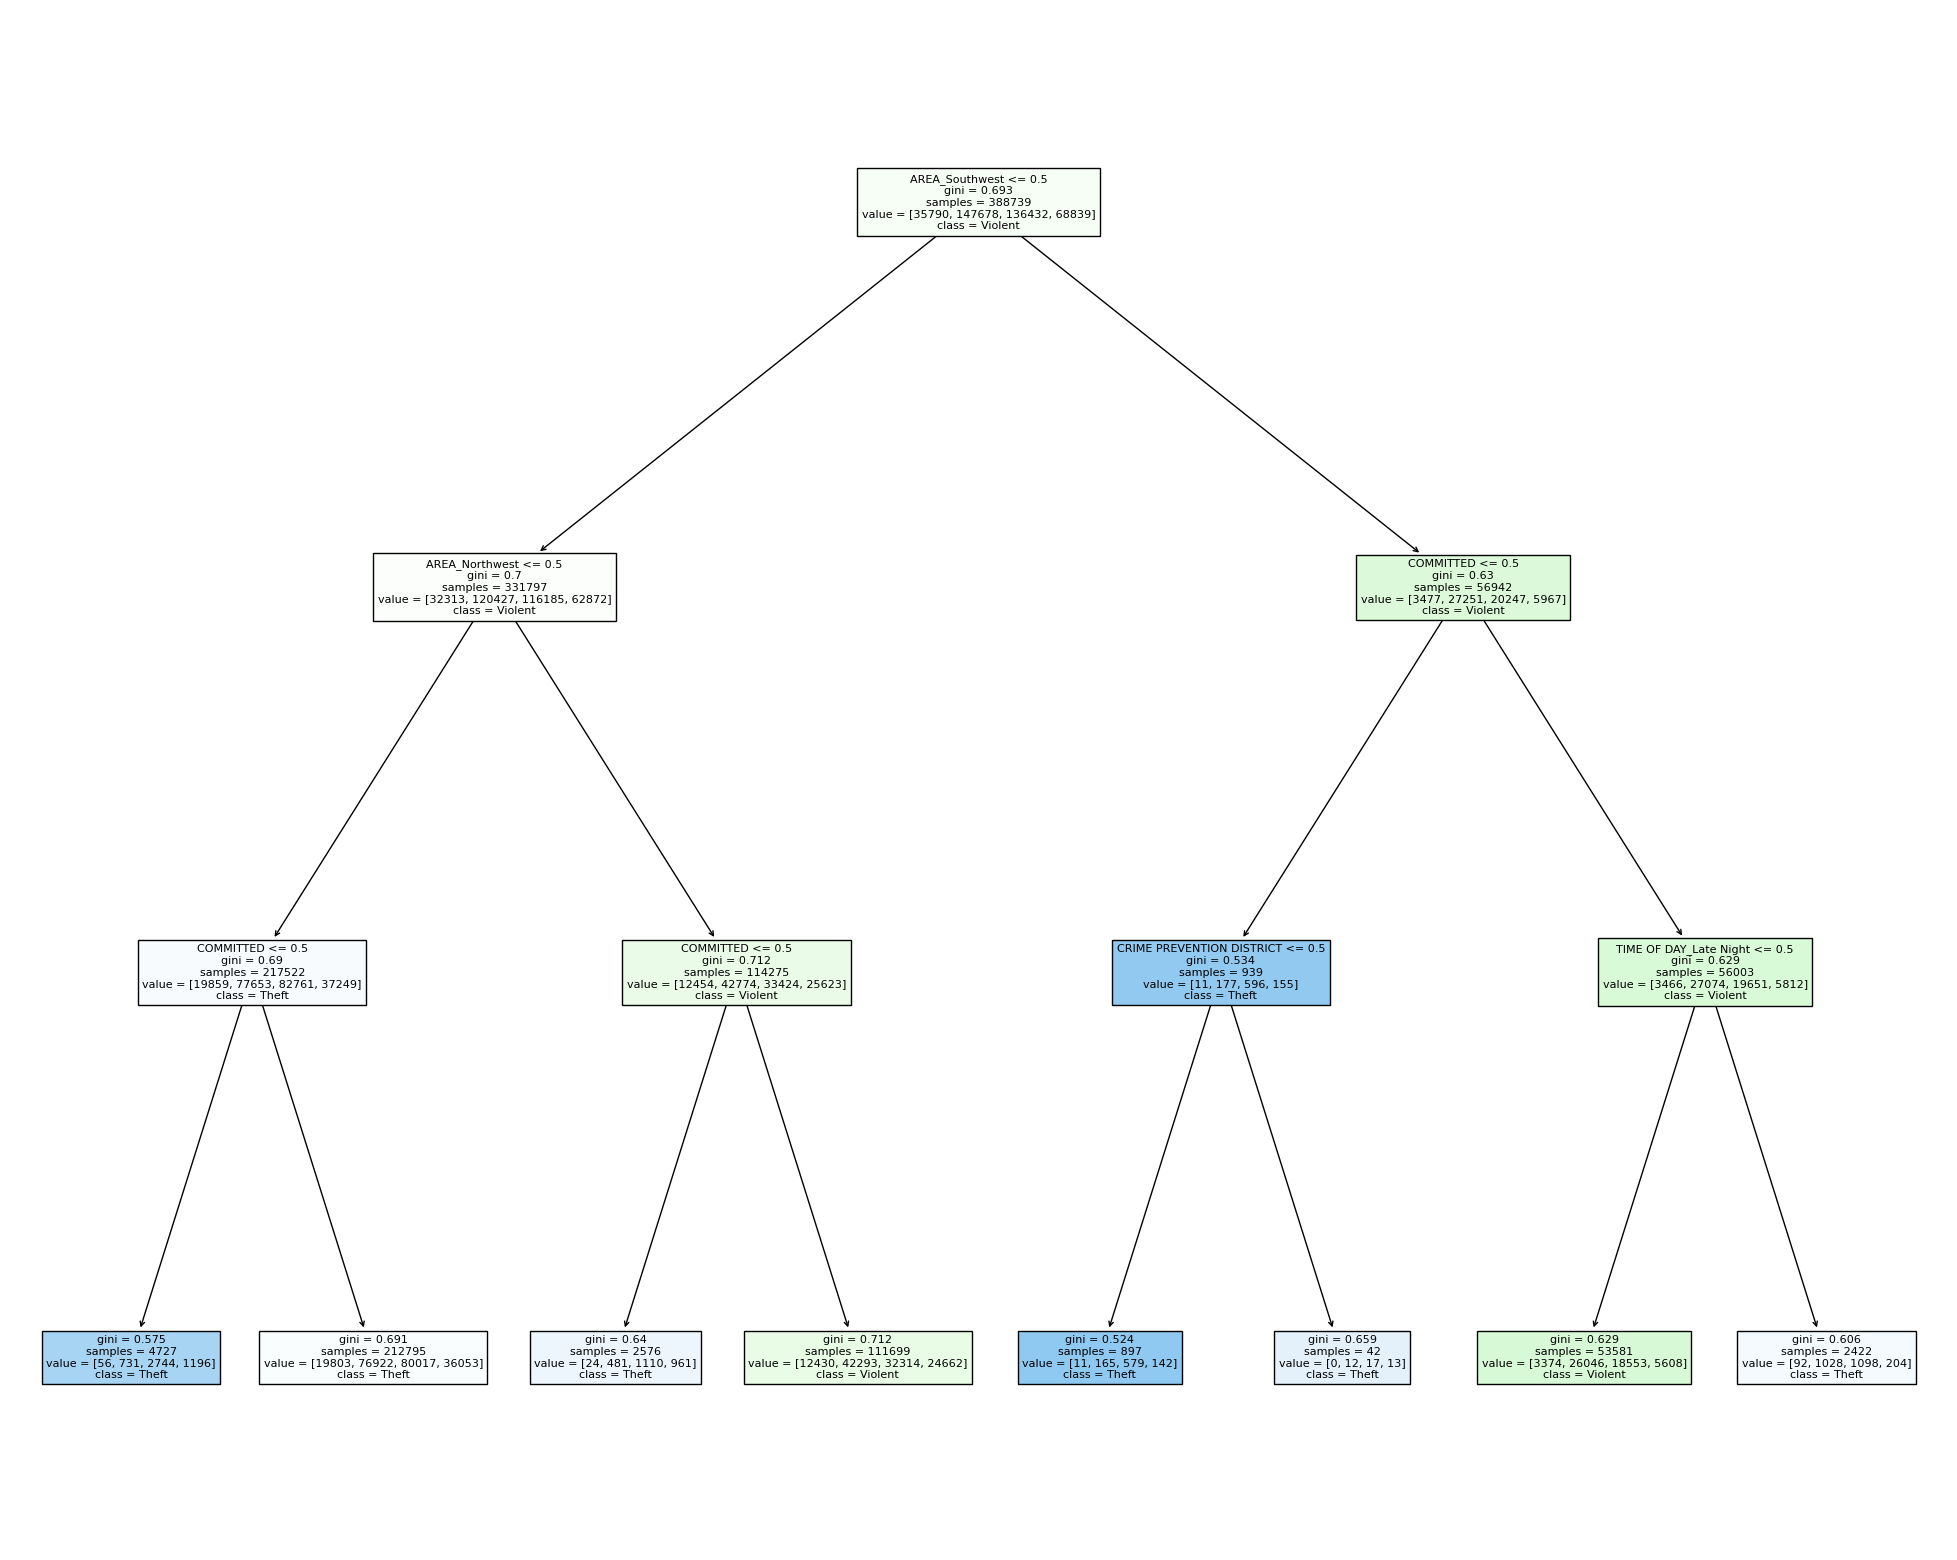

In [46]:
#train decision tree on new dataset
y_data_new = crime_data[['CRIME_NEW']]

x_train, x_test, y_train_new, y_test_new = train_test_split(x_data, y_data_new, test_size=0.2, random_state=42)

tree_clf_new = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_new.fit(x_train, y_train_new)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_clf_new, 
                    feature_names=x_data.columns,  
                    class_names=y_data_new.astype(str).CRIME_NEW.unique(),
                    filled=True)

In [47]:
tree_clf_new.score(x_test, y_test_new)

0.3973864279466996

[Text(0.5, 0.875, 'AREA_Southwest <= 0.5\ngini = 0.75\nsamples = 388739\nvalue = [97184.75, 97184.75, 97184.75, 97184.75]\nclass = Theft'),
 Text(0.25, 0.625, 'COMMITTED <= 0.5\ngini = 0.749\nsamples = 331797\nvalue = [87743.247, 79251.262, 82762.183, 88760.726]\nclass = Drugs'),
 Text(0.125, 0.375, 'AREA_Northwest <= 0.5\ngini = 0.622\nsamples = 7303\nvalue = [217.233, 797.6, 2745.324, 3045.185]\nclass = Drugs'),
 Text(0.0625, 0.125, 'gini = 0.621\nsamples = 4727\nvalue = [152.063, 481.06, 1954.636, 1688.475]\nclass = Theft'),
 Text(0.1875, 0.125, 'gini = 0.598\nsamples = 2576\nvalue = [65.17, 316.539, 790.687, 1356.71]\nclass = Drugs'),
 Text(0.375, 0.375, 'AREA_Northwest <= 0.5\ngini = 0.749\nsamples = 324494\nvalue = [87526.014, 78453.663, 80016.859, 85715.541]\nclass = Minor'),
 Text(0.3125, 0.125, 'gini = 0.749\nsamples = 212795\nvalue = [53773.389, 50621.253, 56998.594, 50898.499]\nclass = Theft'),
 Text(0.4375, 0.125, 'gini = 0.744\nsamples = 111699\nvalue = [33752.625, 27832.4

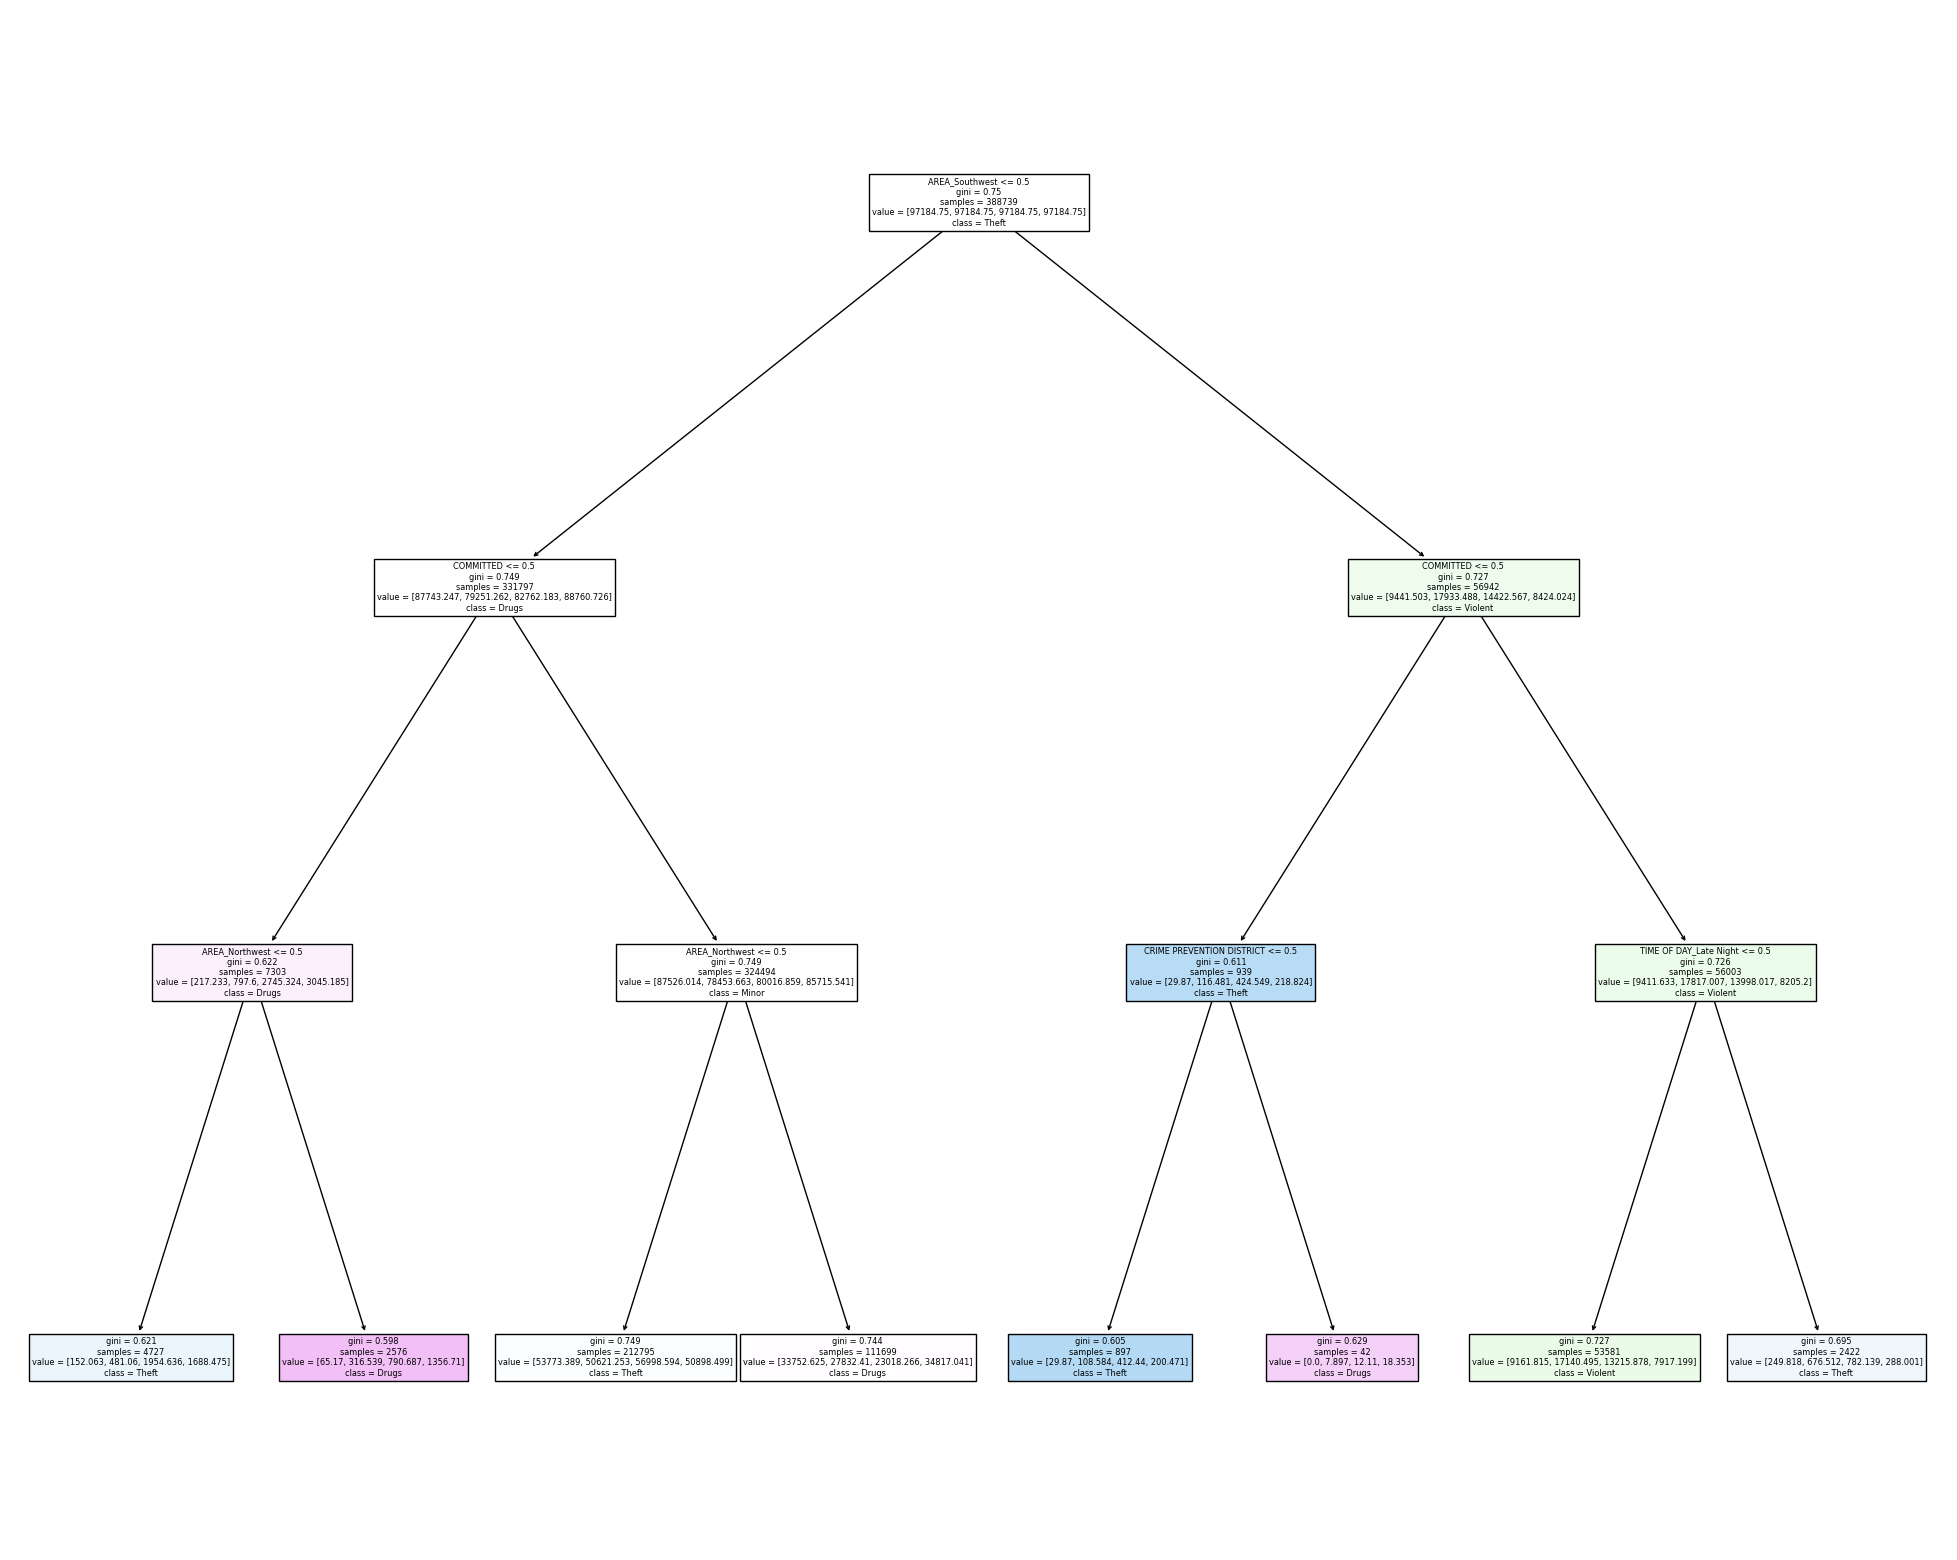

In [38]:
#train new classifier with balanced class weight to make classes reflective of how many labels there are for them in the data
tree_clf_new_2 = DecisionTreeClassifier(max_depth=3, random_state=42, class_weight="balanced")
tree_clf_new_2.fit(x_train, y_train_new)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_clf_new_2, 
                    feature_names=x_data.columns,  
                    class_names=y_data_new.astype(str).CRIME_NEW.unique(),
                    filled=True)

In [39]:
tree_clf_new_2.score(x_test, y_test_new)

0.3521942686628595

[Text(0.6786607142857143, 0.9545454545454546, 'AREA_Southwest <= 0.5\ngini = 0.75\nsamples = 388739\nvalue = [97184.75, 97184.75, 97184.75, 97184.75]\nclass = Theft'),
 Text(0.45321428571428574, 0.8636363636363636, 'COMMITTED <= 0.5\ngini = 0.749\nsamples = 331797\nvalue = [87743.247, 79251.262, 82762.183, 88760.726]\nclass = Drugs'),
 Text(0.2666517857142857, 0.7727272727272727, 'AREA_Northwest <= 0.5\ngini = 0.622\nsamples = 7303\nvalue = [217.233, 797.6, 2745.324, 3045.185]\nclass = Drugs'),
 Text(0.1732142857142857, 0.6818181818181818, 'CRIME PREVENTION DISTRICT <= 0.5\ngini = 0.621\nsamples = 4727\nvalue = [152.063, 481.06, 1954.636, 1688.475]\nclass = Theft'),
 Text(0.105, 0.5909090909090909, 'AREA_Southeast <= 0.5\ngini = 0.62\nsamples = 4099\nvalue = [124.909, 417.884, 1646.197, 1562.828]\nclass = Theft'),
 Text(0.06821428571428571, 0.5, 'TIME OF DAY_Evening <= 0.5\ngini = 0.612\nsamples = 3379\nvalue = [70.601, 350.76, 1306.415, 1392.004]\nclass = Drugs'),
 Text(0.041428571428

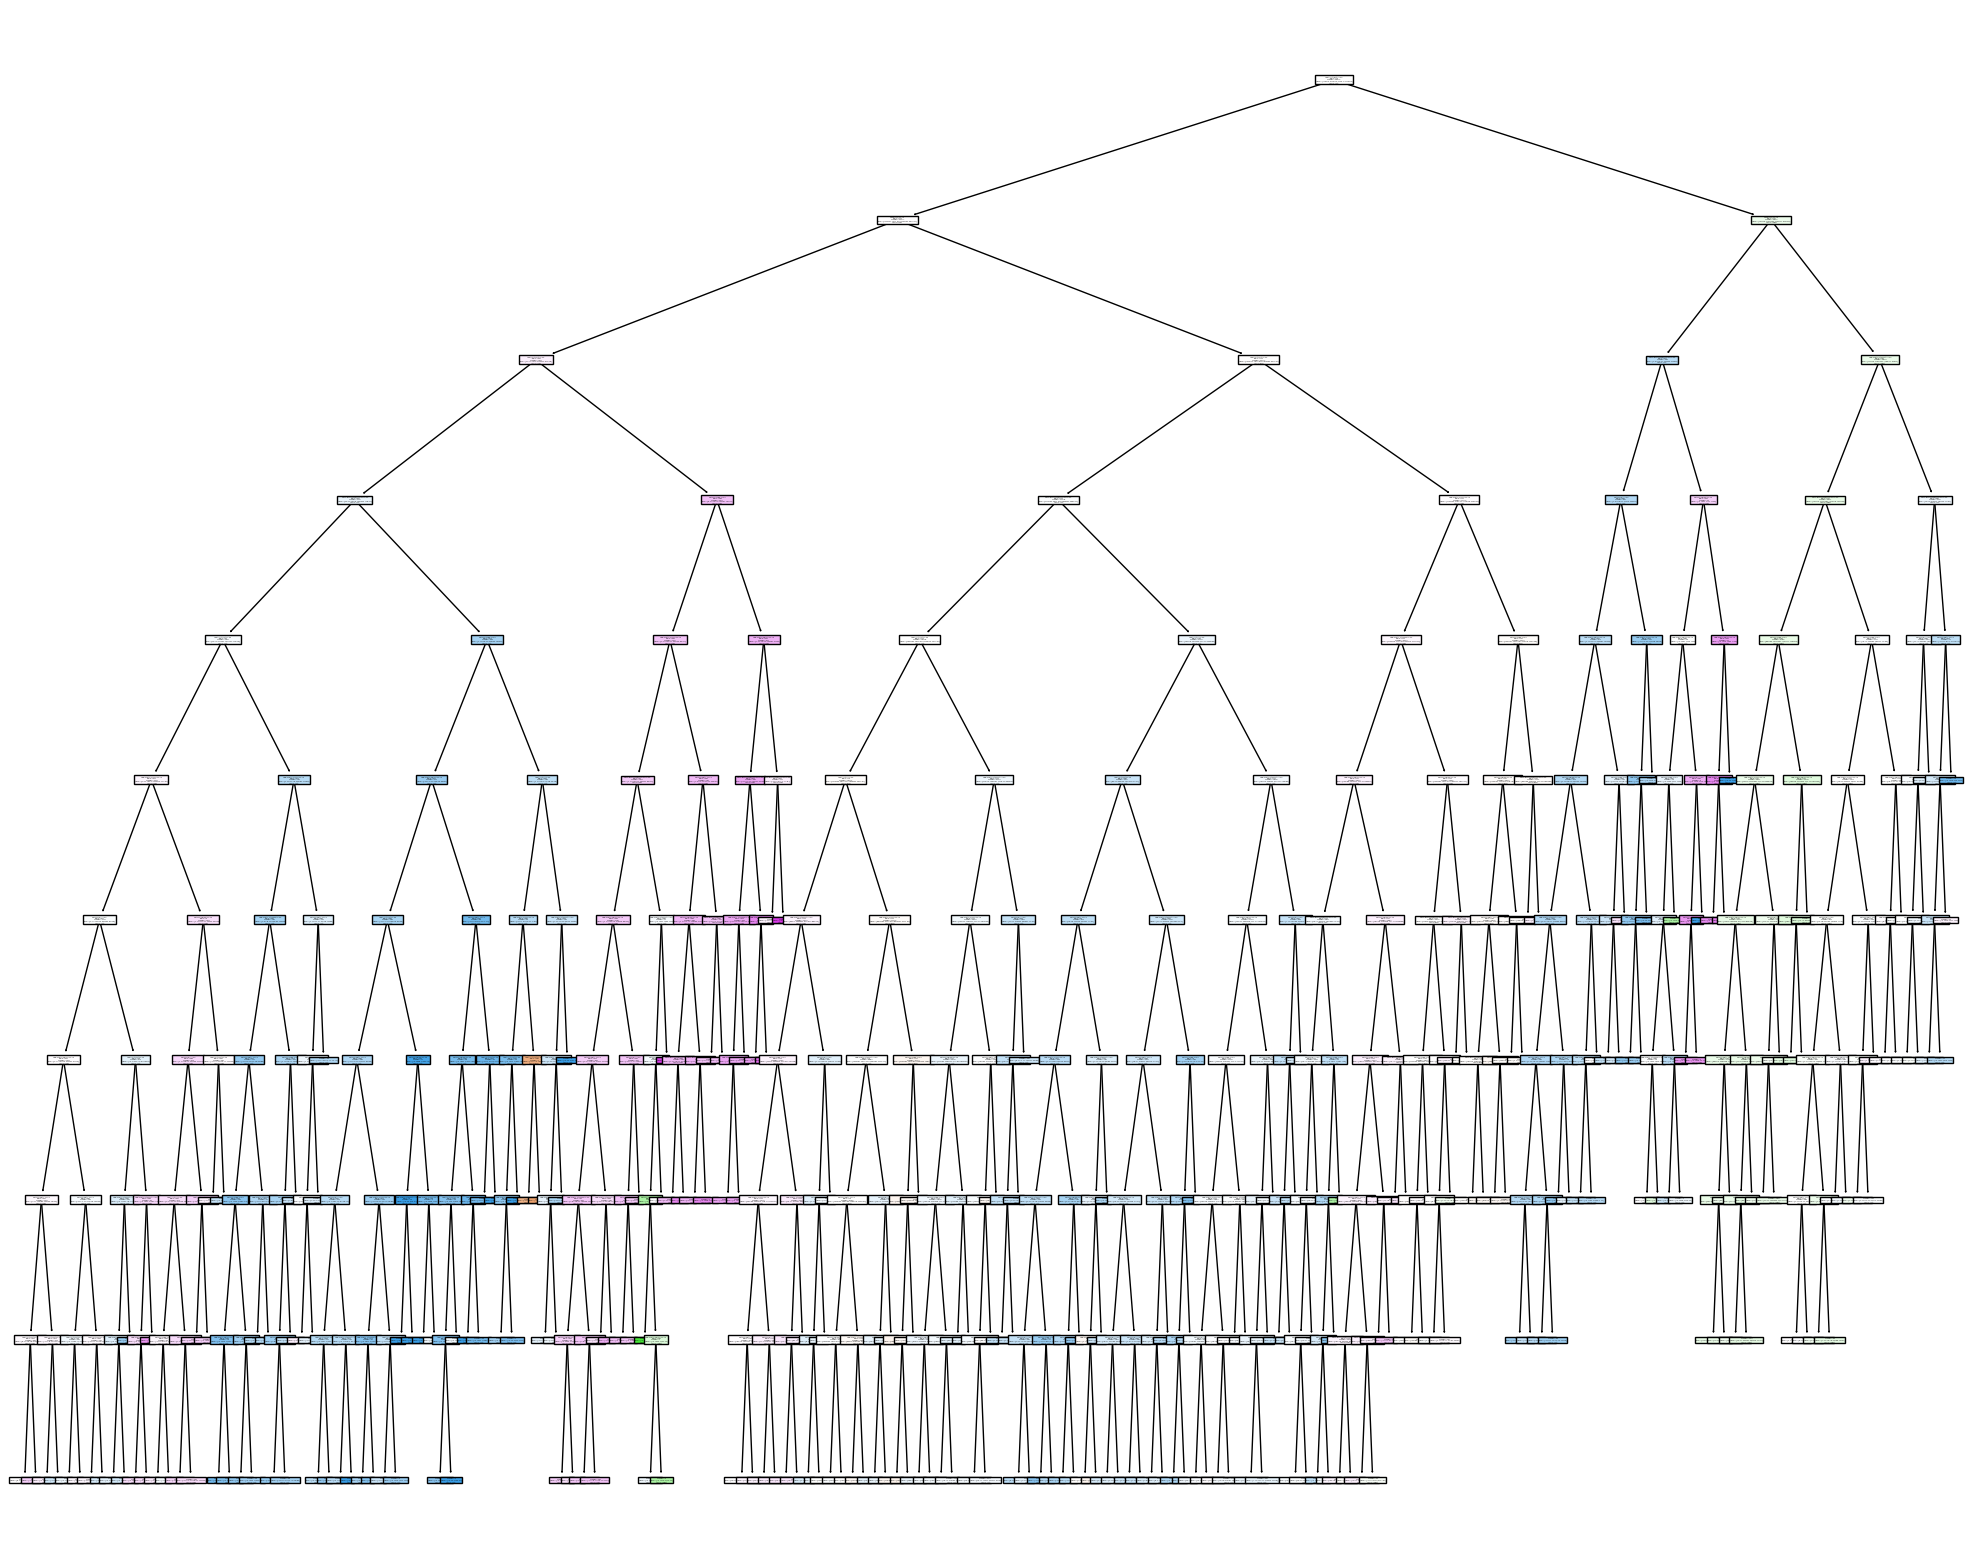

In [40]:
#new tree with higher max depth for the balanced class weights
tree_clf_new_3 = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")
tree_clf_new_3.fit(x_train, y_train_new)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_clf_new_3, 
                    feature_names=x_data.columns,  
                    class_names=y_data_new.astype(str).CRIME_NEW.unique(),
                    filled=True)

In [41]:
tree_clf_new_3.score(x_test, y_test_new)

0.2550908061943716